In [ ]:
%%capture --no-display
from dask.distributed import Client
client = Client(address = 'tcp://192.168.62.207:8786')
client

In [ ]:
import dask.bag as db import json
bag = db.read_text(f'/export/scratch1/home/kruit/nary/output/tabel-164k/8-triples/*').map(json.loads).persist()
bag.count().compute()

In [ ]:
triples = bag.map(lambda x:x['triples']).flatten().distinct('hash ').persist()
triples.count().compute()

## Property tail

In [3]:
import trident
g = trident.Db('/export/scratch1/home/kruit/nary/data/wikidata.tridentdb')
p_count = {p: g.count_p(p) for p in g.all_p()}
puri_name = {l.split(' ', 1)[0]:l for l in map(str.strip, open('/export/scratch1/home/kruit/nary/data/kb/wikidata/wikidata-properties.txt'))}
def pname(p):
    puri = g.lookup_str(p)
    if puri:
        return puri_name.get(puri[1:-1].replace('http://www.wikidata.org/prop/direct/', ''))

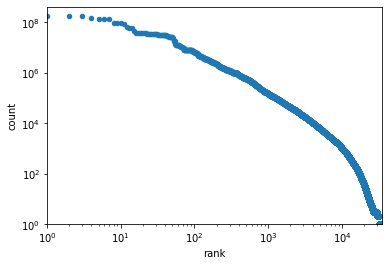

In [4]:
import pandas as pd
df = pd.Series(p_count).to_frame('count')
df = df.sort_values('count', ascending=False).reset_index()
df['rank'] = df.index

def loglog(df, x, y):
    return df.plot.scatter(x, y, loglog=True, xlim=[1,df[x].max()], ylim=[1,df[y].max()])
loglog(df, 'rank', 'count')

In [ ]:
def props(tables):
    ps = []
    for t in tables:
        for tr in t.get('triples'):
            if tr.get('kind') == 'property': ps.append(tr.get('p'))
                return ps
            
from collections import Counter
freq = dict(bag.map_partitions(props).frequencies())
p_freq = pd.Series({g.lookup_id(f'<{puri}>'):f for puri,f in freq.i tems()}, name='freq')
df2 = df.join(p_freq, on='index')
df2 = df2[~df2['freq'].isna()]
df2.plot.scatter('rank', 'freq', loglog=True, xlim=[1,df2['rank'].m ax()], ylim=[1,df2['freq'].max()])

In [ ]:
for p in df2.loc[(df2['freq'] / df2['count']).sort_values().index[::-1]][:10].itertuples():
    print(pname(p.index), p.count, p.freq)

In [ ]:
def tprops(triples): ps = []
    for tr in triples:
        if tr.get('kind') == 'property':
            ps.append(tr.get('p'))
    return ps

freq = dict(triples.map_partitions(tprops).frequencies().compute())
p_freq = pd.Series({g.lookup_id(f'<{puri}>'):f for puri,f in freq.items()}, name='freq')
df2 = df.join(p_freq, on='index')
df2 = df2[~df2['freq'].isna()]

loglog(df2, 'rank', 'freq')

In [ ]:
for p in df2.loc[(df2['freq'] / df2['count']).sort_values().index[::-1]][:10].itertuples():
    print(pname(p.index), p.count, p.freq)

In [ ]:
pcode = 'P4599'

def so(triples, pid):
    for t in triples:
        if t.get('p', '').endswith(pid):
            score = t.get('s_score', 1) , min(1, t.get('p_score',1)), t.get('o_score', 1)
            yield t.get('s'), t.get('o'), score
            
pid = g.lookup_id(f'<http://www.wikidata.org/prop/direct/{pcode}>')
for su, ou, score in triples.map_partitions(so, pcode).take(10):
    s, o = g.lookup_id('<%s>'%su), g.lookup_id('<%s>'%ou)
    print(su, ou, g.exists(s,pid,o), score)

In [ ]:
triples.filter(lambda t: t['kind'] == 'property' and t['p'].endswith(pcode)).take(1)

In [ ]:
p_scores = triples.map_partitions(lambda ts: [min(1,t['p_score']) for t in ts if t['kind'] == 'property' and 'p_score' in t]).compute ()
pd.Series(p_scores).plot.hist(bins=100)

## Subject tail

In [ ]:
get_uris = lambda ts: [i.rsplit('/', 1)[-1] for t in ts for i in [t.get('s'), t.get('o')] if isinstance(i, str)]
all_uris = set(triples.map_partitions(all_uris).distinct().compute())
len(all_uris)

In [ ]:
import tqdm
ss = set(g.lookup_id(f'<http://www.wikidata.org/entity/{u}>') for u in tqdm.tqdm(all_uris))
len(ss)

In [ ]:
s_count = {s: g.count_s(s) for s in tqdm.tqdm(ss) if s and g.count_s(s) > 1}

import pandas as pd
stail = pd.Series(s_count).to_frame('count')
stail = stail.sort_values('count', ascending=False).reset_index() stail['rank'] = stail.index

def loglog(df, x, y):
    return df.plot.scatter(x, y, loglog=True, xlim=[1,df[x].max()], ylim=[1,df[y].max()])
loglog(stail, 'rank', 'count')

In [ ]:
triple_s = triples.map_partitions(lambda ts: [t.get('s') for t in ts if t['kind'] == 'property'])

s_freq = pd.Series({g.lookup_id('<%s>'%s):f for s,f in triple_s.frequencies()}, name='freq')
stail2 = stail.join(s_freq, on='index')
stail2 = stail2[~stail2['freq'].isna()]

loglog(stail2, 'rank', 'freq')

In [ ]:
import numpy as np
smeans = stail2.groupby(10**np.floor(np.log10(stail2['rank'])))['freq'].mean()
smeans.plot.bar(logy=True, ylabel='Mean subject extraction frequency')

## Object tal

In [ ]:
o_count = {s: g.count_o(s) for s in tqdm.tqdm(ss) if s and g.count_o(s) > 1}

import pandas as pd
otail = pd.Series(o_count).to_frame('count')
otail = otail.sort_values('count', ascending=False).reset_index() otail['rank'] = otail.index

def loglog(df, x, y):
    return df.plot.scatter(x, y, loglog=True, xlim=[1,df[x].max()], ylim=[1,df[y].max()])

loglog(otail, 'rank', 'count')

In [ ]:
triple_o = triples.map_partitions(lambda ts: [t.get('o') for t in ts if t['kind'] == 'property' and isinstance(t.get('o'), str)])

o_freq = pd.Series({g.lookup_id('<%s>'%s):f for s,f in triple_o.frequencies()}, name='freq')
otail2 = otail.join(o_freq, on='index')
otail2 = otail2[~otail2['freq'].isna()]

loglog(otail2, 'rank', 'freq')

In [ ]:
import numpy as np
omeans = otail2.groupby(10**np.floor(np.log10(otail2['rank'])))['freq'].mean()
omeans.plot.bar(logy=True, ylabel='Mean object extraction frequency')